In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.model_selection import train_test_split

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [119]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../GVR Historical Data.csv')

In [120]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [121]:
tranformData(df)

In [122]:
#Định dạng lại cột Date từ obj -> datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
# Chuyển cột Date làm index để lập biểu đồ so sánh về sau
df.index = df.Date
df.drop('Date', axis=1, inplace=True)

In [123]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-03-22,10736.0,10834.0,11130.0,10046.0,260800.0,0.0000
2018-03-23,10342.0,10440.0,10440.0,9849.0,111800.0,-0.0367
2018-03-26,10145.0,10046.0,10342.0,10046.0,267800.0,-0.0190
2018-03-27,10736.0,10637.0,10834.0,10342.0,52200.0,0.0583
2018-03-28,11327.0,10736.0,11622.0,10637.0,139800.0,0.0550
...,...,...,...,...,...,...
2023-05-29,18200.0,17200.0,18200.0,17050.0,6080000.0,0.0581
2023-05-30,18400.0,18300.0,18500.0,17850.0,4580000.0,0.0110
2023-05-31,18200.0,18450.0,18450.0,18000.0,3140000.0,-0.0109


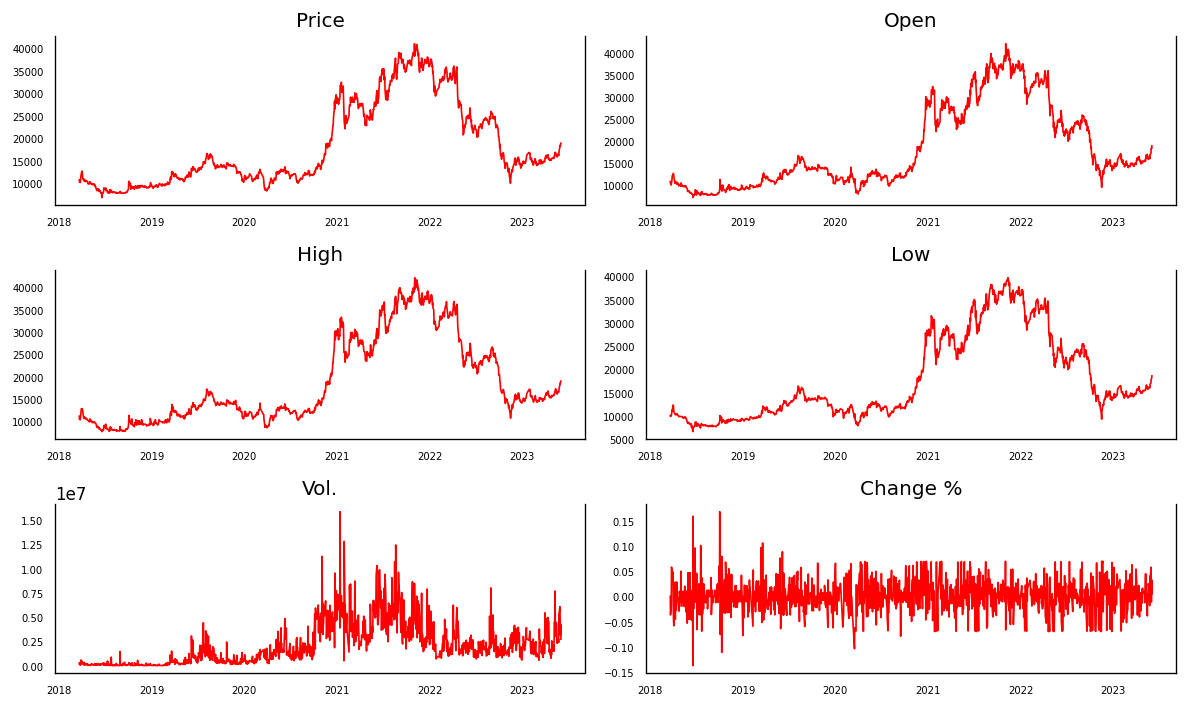

In [124]:


# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
     

In [125]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,Price_x,Open_x,High_x,Low_x,Vol._x,Change %_x
Price_y,1.0000,0.0002,0.0001,0.0037,0.0000,0.0019
Open_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
High_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
Low_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
Vol._y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0004
Change %_y,0.0887,0.1597,0.1519,0.0845,0.1563,1.0000


In [126]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  784.03    > 83.9383   =>   True
Open   ::  535.02    > 60.0627   =>   True
High   ::  324.67    > 40.1749   =>   True
Low    ::  129.39    > 24.2761   =>   True
Vol.   ::  39.62     > 12.3212   =>   True
Change % ::  0.17      > 4.1296    =>   False


In [127]:
nobs=int(0.2*len(df))
n_train = int(0.6 * len(df))
n_test = int(0.2 * len(df))
n_validation = len(df) - n_train - n_test
nobs_val= n_validation
df_train = df[:n_train]
df_test = df[n_train:n_train+n_test]
df_validation = df[n_train+n_test:]

# Kiểm tra kích thước
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)

(775, 6)
(258, 6)
(259, 6)


In [128]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [129]:
# ADF Test on each column
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.4149
 No. Lags Chosen       = 11
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.9076. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.4112
 No. Lags Chosen       = 11
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.9082. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit

In [130]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [131]:
# ADF Test trên từng cột của DataFrame chứa sự khác biệt đầu tiên
for name in df_differenced.columns:
    adfuller_test(df_differenced[name], name=name)
    print('\n')


    Augmented Dickey-Fuller Test on "Price"

 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.6713
 No. Lags Chosen       = 10
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.8777
 No. Lags Chosen       = 10
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.0241
 No. La

In [132]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [133]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.9919
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.5794
 No. Lags Chosen       = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.7726
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

In [134]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  69.29561152191765
BIC :  69.54853555184128
FPE :  1.2436638169759146e+30
HQIC:  69.39293663600593 

Lag Order = 2
AIC :  67.64009539124658
BIC :  68.1102895457705
FPE :  2.3753549342419468e+29
HQIC:  67.82103701546602 

Lag Order = 3
AIC :  66.69954631660154
BIC :  67.38745348373483
FPE :  9.274083885429973e+28
HQIC:  66.96428508996507 

Lag Order = 4
AIC :  66.00644128755125
BIC :  66.91250584597238
FPE :  4.6375963643471005e+28
HQIC:  66.35515847168243 

Lag Order = 5
AIC :  65.64204287463195
BIC :  66.76671070062865
FPE :  3.2217464627586596e+28
HQIC:  66.07492035669812 

Lag Order = 6
AIC :  65.34560265744487
BIC :  66.68932113189537
FPE :  2.3956862289036084e+28
HQIC:  65.86282295310788 

Lag Order = 7
AIC :  65.12832506861893
BIC :  66.6915430840146
FPE :  1.9283243075717035e+28
HQIC:  65.73007132500351 

Lag Order = 8
AIC :  64.94141628569425
BIC :  66.72458425320406
FPE :  1.6001340790354931e+28
HQIC:  65.62787228437409 

Lag Order = 9
AIC :  64.63758738970

In [135]:
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,73.37,73.40,7.296e+31,73.38
1,69.34,69.60,1.306e+30,69.44
2,67.68,68.16,2.478e+29,67.87
3,66.74,67.44,9.665e+28,67.01
4,66.04,66.96,4.807e+28,66.40
5,65.68,66.82,3.355e+28,66.12
6,65.39,66.75,2.494e+28,65.91
7,65.17,66.76,2.016e+28,65.78
8,64.98,66.79,1.669e+28,65.68
9,64.69,66.71*,1.241e+28,65.47


In [136]:
model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Jun, 2023
Time:                     00:31:46
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    66.7246
Nobs:                     765.000    HQIC:                   65.6279
Log likelihood:          -31059.0    FPE:                1.60013e+28
AIC:                      64.9414    Det(Omega_mle):     1.10250e+28
--------------------------------------------------------------------
Results for equation Price
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.063615        16.716775           -0.004           0.997
L1.Price           -0.451598         0.094972           -4.755           0.000
L1.Open             0.135379         0.072888            1.857      

In [137]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

8


array([[ 2.440e+02, -1.462e+03, -2.337e+03, -1.752e+03, -5.400e+05,
         6.680e-02],
       [ 1.850e+03,  9.260e+02,  2.191e+03,  2.289e+03,  2.890e+06,
         7.110e-02],
       [-8.270e+02,  1.460e+03,  3.410e+02, -2.930e+02, -1.540e+06,
        -1.195e-01],
       [-1.218e+03, -3.019e+03, -2.094e+03, -2.142e+03, -1.070e+06,
        -1.100e-02],
       [ 4.870e+02,  1.364e+03,  9.260e+02,  1.947e+03,  2.030e+06,
         6.880e-02],
       [ 4.800e+01,  0.000e+00,  2.430e+02, -8.760e+02, -1.650e+06,
        -1.740e-02],
       [-5.350e+02, -9.800e+01, -6.820e+02, -2.920e+02,  9.500e+05,
        -2.380e-02],
       [ 3.410e+02, -8.760e+02, -2.430e+02, -3.410e+02, -7.600e+05,
         3.560e-02]])

In [138]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[n_train:n_train+n_test], columns=df.columns + '_2d')
df_forecast

,Price_2d,Open_2d,High_2d,Low_2d,Vol._2d,Change %_2d
Date,,,,,,
2021-05-11,418.370145,861.083637,816.835262,978.244954,588182.685480,0.015611
2021-05-12,-18.162812,249.880089,-144.643445,-249.865039,242800.728521,-0.041232
2021-05-13,-334.023193,-417.207984,-32.461548,28.280585,-255421.640316,0.004247
2021-05-14,170.469052,95.865057,-24.961502,-67.492221,-307052.427860,0.027871
2021-05-17,71.937489,53.137687,86.815855,46.977572,-78442.592159,-0.035168
...,...,...,...,...,...,...
2022-05-16,-0.041709,-0.142479,-0.113486,-0.083948,-2.306852,0.000005
2022-05-17,-0.041709,-0.142479,-0.113486,-0.083948,-2.306852,0.000005
2022-05-18,-0.041709,-0.142479,-0.113486,-0.083948,-2.306852,0.000005


In [139]:
# Forecast val
fc_val = model_fitted.forecast(y=forecast_input, steps=nobs_val)
df_forecast_val = pd.DataFrame(fc_val, index=df.index[n_train+n_test:], columns=df.columns + '_2d')
df_forecast_val

,Price_2d,Open_2d,High_2d,Low_2d,Vol._2d,Change %_2d
Date,,,,,,
2022-05-23,418.370145,861.083637,816.835262,978.244954,588182.685480,0.015611
2022-05-24,-18.162812,249.880089,-144.643445,-249.865039,242800.728521,-0.041232
2022-05-25,-334.023193,-417.207984,-32.461548,28.280585,-255421.640316,0.004247
2022-05-26,170.469052,95.865057,-24.961502,-67.492221,-307052.427860,0.027871
2022-05-27,71.937489,53.137687,86.815855,46.977572,-78442.592159,-0.035168
...,...,...,...,...,...,...
2023-05-29,-0.041709,-0.142479,-0.113486,-0.083948,-2.306852,0.000005
2023-05-30,-0.041709,-0.142479,-0.113486,-0.083948,-2.306852,0.000005
2023-05-31,-0.041709,-0.142479,-0.113486,-0.083948,-2.306852,0.000005


In [140]:
def invert_transformation(df_train, df_forecast_val, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc_val = df_forecast_val.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc_val[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc_val[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc_val[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc_val[str(col)+'_1d'].cumsum()
    return df_fc_val

In [141]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [142]:
df_results_val = invert_transformation(df_train, df_forecast_val, second_diff=True)        
df_results_val.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]

,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
Date,,,,,,
2022-05-23,24280.370145,23944.083637,24533.835262,23769.244954,2.578183e+06,0.023411
2022-05-24,24534.577478,24276.047363,24622.027080,23864.624869,2.969166e+06,0.011589
2022-05-25,24454.761618,24190.803105,24677.757349,23988.285368,3.104728e+06,0.004015
2022-05-26,24545.414809,24201.423904,24708.526116,24044.453647,2.933237e+06,0.024312
2022-05-27,24708.005489,24265.182391,24826.110739,24147.599498,2.683304e+06,0.009440
...,...,...,...,...,...,...
2023-05-29,30591.368211,20269.528501,19407.886476,30025.393623,4.754802e+06,0.445977
2023-05-30,30610.306637,20235.731386,19372.504366,30038.609652,4.762324e+06,0.448303
2023-05-31,30629.203355,20201.791792,19337.008770,30051.741734,4.769843e+06,0.450634


In [143]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]

,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
Date,,,,,,
2021-05-11,24280.370145,23944.083637,24533.835262,23769.244954,2.578183e+06,0.023411
2021-05-12,24534.577478,24276.047363,24622.027080,23864.624869,2.969166e+06,0.011589
2021-05-13,24454.761618,24190.803105,24677.757349,23988.285368,3.104728e+06,0.004015
2021-05-14,24545.414809,24201.423904,24708.526116,24044.453647,2.933237e+06,0.024312
2021-05-17,24708.005489,24265.182391,24826.110739,24147.599498,2.683304e+06,0.009440
...,...,...,...,...,...,...
2022-05-16,30572.388076,20303.183136,19443.155100,30012.093645,4.747278e+06,0.443655
2022-05-17,30591.368211,20269.528501,19407.886476,30025.393623,4.754802e+06,0.445977
2022-05-18,30610.306637,20235.731386,19372.504366,30038.609652,4.762324e+06,0.448303


In [144]:
# Chuyển đổi dự đoán về đơn vị ban đầu
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to the original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col) + '_1d'] = (df_train[col].iloc[-1] - df_train[col].iloc[-2]) + df_fc[col + '_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + df_fc[col + '_1d'].cumsum()
    return df_fc

df_future_results = invert_transformation(df_train, df_future, second_diff=True)
df_future_results.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]


,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
0,24280.370145,23944.083637,24533.835262,23769.244954,2.578183e+06,0.023411
1,24534.577478,24276.047363,24622.027080,23864.624869,2.969166e+06,0.011589
2,24454.761618,24190.803105,24677.757349,23988.285368,3.104728e+06,0.004015
3,24545.414809,24201.423904,24708.526116,24044.453647,2.933237e+06,0.024312
4,24708.005489,24265.182391,24826.110739,24147.599498,2.683304e+06,0.009440
...,...,...,...,...,...,...
253,30572.388076,20303.183136,19443.155100,30012.093645,4.747278e+06,0.443655
254,30591.368211,20269.528501,19407.886476,30025.393623,4.754802e+06,0.445977
255,30610.306637,20235.731386,19372.504366,30038.609652,4.762324e+06,0.448303
256,30629.203355,20201.791792,19337.008770,30051.741734,4.769843e+06,0.450634


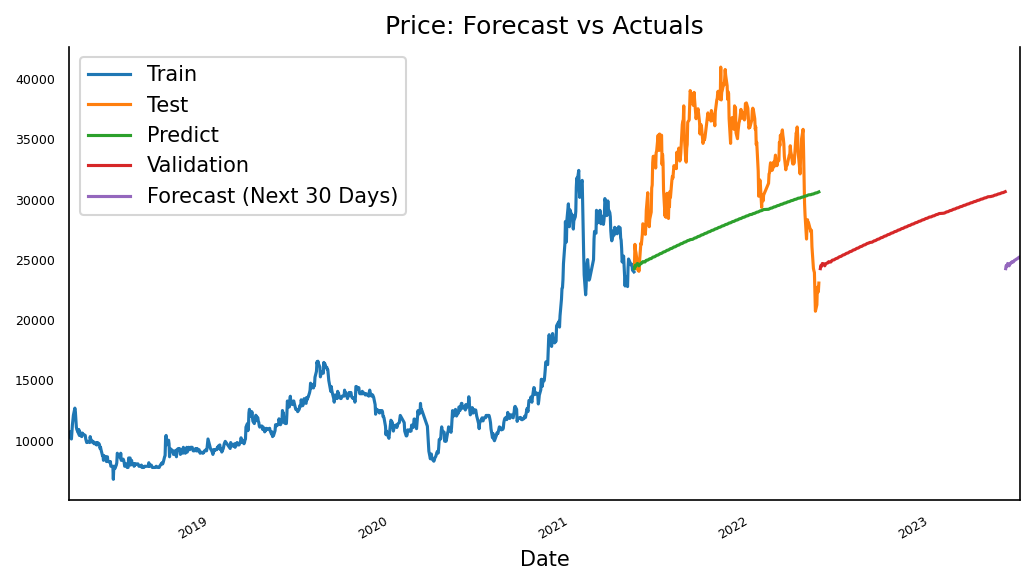

In [145]:
import datetime

# Sử dụng model_fitted để dự đoán 30 ngày tiếp theo
n_forecast_days = 30
fc = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)

# Chuyển đổi dự đoán thành DataFrame
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

# Chuyển đổi dự đoán về đơn vị ban đầu
df_future_results = invert_transformation(df_train, df_future, second_diff=True)

# Tạo index cho 30 ngày tiếp theo
future_dates = pd.date_range(start=df.index[-1] + datetime.timedelta(days=1), periods=n_forecast_days, freq='D')

# Tạo DataFrame chứa dự đoán cho 30 ngày tiếp theo
df_future_forecast = pd.DataFrame(df_future_results.values, index=future_dates, columns=df_future_results.columns)

# Vẽ đồ thị
fig, ax = plt.subplots(dpi=150, figsize=(7, 4))

# Chọn cột dữ liệu cần vẽ
col = 'Price'

# Vẽ dữ liệu huấn luyện
df_train[col].plot(legend=True, ax=ax, label='Train')

# Vẽ dữ liệu kiểm tra
df_test[col][-nobs:].plot(legend=True, ax=ax, label='Test')

# Vẽ dự đoán trên tập huấn luyện
df_results[col+'_forecast'].plot(legend=True, ax=ax, label='Predict').autoscale(axis='x', tight=True)

# Vẽ dự đoán trên tập kiểm tra
df_results_val[col+'_forecast'].plot(legend=True, ax=ax, label='Validation').autoscale(axis='x', tight=True)

# Vẽ dự đoán cho 30 ngày tiếp theo
df_future_forecast[col + '_forecast'].plot(legend=True, ax=ax, label='Forecast (Next 30 Days)')

# Định dạng đồ thị và tiêu đề
ax.set_title(col + ": Forecast vs Actuals")
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines["top"].set_alpha(0)
ax.tick_params(labelsize=6)

plt.tight_layout()


In [146]:
def forecast_accuracy(forecast, actual):
    forecast = np.array(forecast)  # Chuyển đổi dự đoán thành numpy array
    actual = np.array(actual)  # Chuyển đổi dữ liệu thực tế thành numpy array
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return {'mape': mape, 'rmse': rmse, }


print('Forecast Accuracy of: Price')
accuracy_prod = forecast_accuracy(df_results['Price_forecast'].values, df_test['Price'])
for k, v in accuracy_prod.items():
    print(str.title(k), ': ', round(v, 4))



Forecast Accuracy of: Price
Mape :  0.1883
Rmse :  7216.4302
